C:\Users\pavan\AppData\Local\anaconda3\envs\prompt\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\pavan\AppData\Local\anaconda3\envs\prompt\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\pavan\AppData\Local\anaconda3\envs\prompt\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipe

Enter your Google Gemini API key:  ········
Enter the image URL (or press Enter to skip):  https://fal.media/files/elephant/zVhronC-mL1yhgLj3ubBu.png


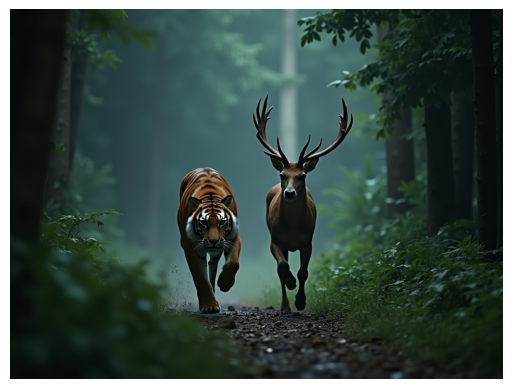

Generating description...
Image description: I am sorry, I cannot access or view external websites or images. Therefore, I cannot provide a description of the image you have linked. 

If you would like me to describe an image, please provide me with a detailed textual description of it. I can then analyze the elements you describe and provide you with insights. 

Predicting emotion from the description...
Detected Emotion: fear

Prediction Probability:
   emotions   probability
0     anger  2.492321e-02
1   disgust  2.962628e-02
2      fear  8.876449e-01
3       joy  1.270882e-02
4   neutral  5.441264e-09
5   sadness  3.516528e-02
6     shame  5.373520e-06
7  surprise  9.926165e-03


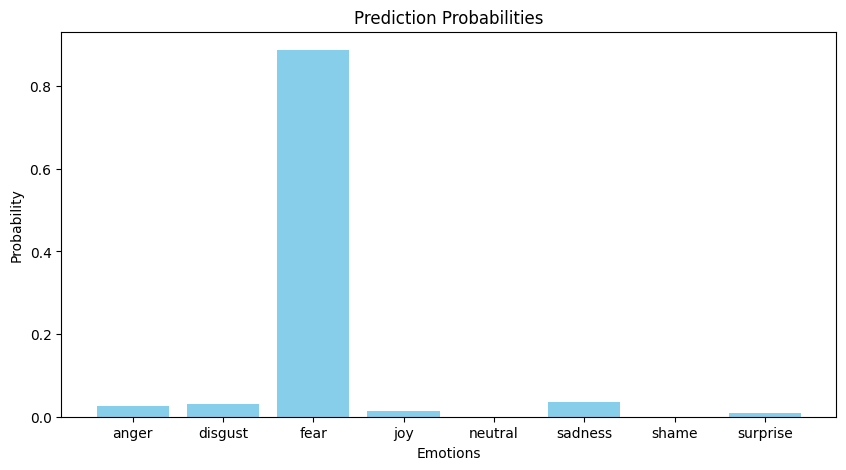

Do you want to enter another URL? (yes/no):  yes
Enter the image URL (or press Enter to skip):  https://fal.media/files/koala/7TE6B8eUOtHGVZgy7Zc0n.png


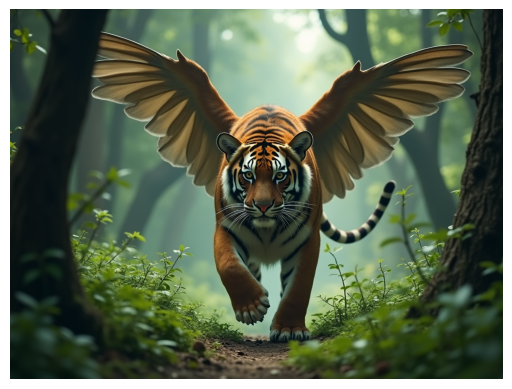

Generating description...
Image description: I am sorry, but I am unable to access or process external websites or specific files, including the one you provided. Therefore, I cannot provide a description of the picture, landscape, buildings, country, settings, or any signs and their suggestions. 

If you would like me to describe an image, please provide the image description or upload the image directly. 

Predicting emotion from the description...
Detected Emotion: sadness

Prediction Probability:
   emotions   probability
0     anger  6.746016e-02
1   disgust  6.445612e-02
2      fear  3.363951e-01
3       joy  3.495515e-04
4   neutral  1.012349e-07
5   sadness  5.198697e-01
6     shame  3.593591e-05
7  surprise  1.143340e-02


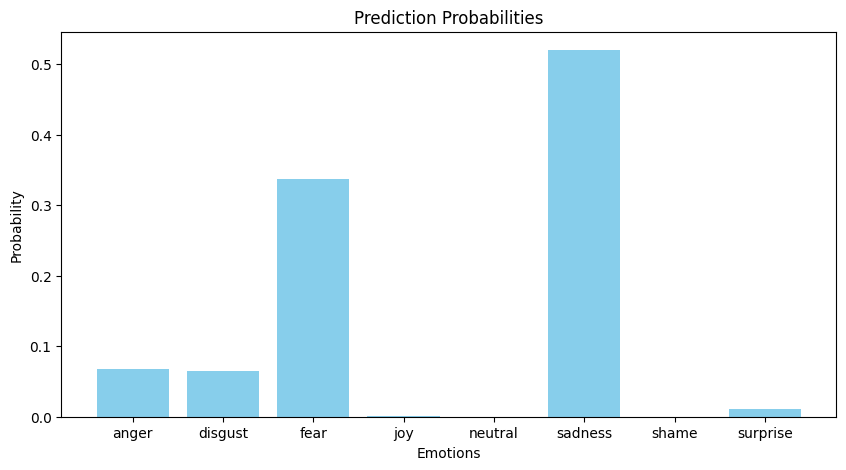

Do you want to enter another URL? (yes/no):  https://fal.media/files/kangaroo/xMkwvnKlRZFDbKR-w5ch3.png


Exiting the program.


In [4]:
# Import necessary libraries
import requests
from PIL import Image
from io import BytesIO
import google.generativeai as genai
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import getpass  # For hidden input

# Load your pre-trained emotion classifier model
pipe_lr = joblib.load(open(r"C:\Users\pavan\Downloads\emotion_classifier_pipe_lr.pkl", "rb"))

# Function to predict emotion from text description
def predict_emotions(docx):
    results = pipe_lr.predict([docx])
    return results[0]

# Function to get prediction probabilities
def get_prediction_proba(docx):
    results = pipe_lr.predict_proba([docx])
    return results

# Function to configure and create the Google Generative AI client
def create_google_client(api_key):
    genai.configure(api_key=api_key)
    
    class ClientFactory:
        def __init__(self):
            self.clients = {}
        
        def register_client(self, name, client_class):
            self.clients[name] = client_class
        
        def create_client(self, name, **kwargs):
            client_class = self.clients.get(name)
            if client_class:
                return client_class(**kwargs)
            raise ValueError(f"Client '{name}' is not registered.")
    
    # Register and create the Google generative AI client
    client_factory = ClientFactory()
    client_factory.register_client('google', genai.GenerativeModel)

    client_kwargs = {
        "model_name": "gemini-1.5-flash",
        "generation_config": {"temperature": 0.8},
        "system_instruction": None,
    }

    client = client_factory.create_client('google', **client_kwargs)
    return client

# Main function to run the process
def main():
    # Input: Google Gemini API key with password-like input
    api_key = getpass.getpass("Enter your Google Gemini API key: ")

    if api_key:
        # Create the Google client
        client = create_google_client(api_key)
        
        while True:  # Loop for entering multiple URLs
            # Input: Image URL
            image_url = input("Enter the image URL (or press Enter to skip): ")

            if image_url:
                try:
                    # Load and display the image from URL
                    response = requests.get(image_url)
                    img = Image.open(BytesIO(response.content))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.show()
                    
                    # Generate image description
                    print("Generating description...")
                    user_content = """Describe this picture, landscape, buildings, country, settings, and art style if any dictated. 
                                      Identify any signs and indicate what they may suggest."""
                    response = client.generate_content([user_content, image_url], stream=True)
                    response.resolve()
                    description = response.text
                    print(f"Image description: {description}")
                    
                except Exception as e:
                    print(f"Error loading image: {e}")
                    description = None
            else:
                description = None

            # Input: Manual Description
            if not description:
                description = input("Enter a manual description for emotion detection: ")

            if description:
                # Predict emotion based on the description
                print("Predicting emotion from the description...")
                emotion = predict_emotions(description)
                print(f"Detected Emotion: {emotion}")
                
                # Show prediction probabilities
                probability = get_prediction_proba(description)
                proba_df = pd.DataFrame(probability, columns=pipe_lr.classes_)
                proba_df_clean = proba_df.T.reset_index()
                proba_df_clean.columns = ["emotions", "probability"]
                
                print("\nPrediction Probability:")
                print(proba_df_clean)
                
                # Plot the probabilities
                plt.figure(figsize=(10, 5))
                plt.bar(proba_df_clean['emotions'], proba_df_clean['probability'], color='skyblue')
                plt.xlabel('Emotions')
                plt.ylabel('Probability')
                plt.title('Prediction Probabilities')
                plt.show()
            else:
                print("No description provided. Unable to predict emotions.")

            # Prompt to continue or exit
            continue_input = input("Do you want to enter another URL? (yes/no): ").strip().lower()
            if continue_input != 'yes':
                print("Exiting the program.")
                break
    else:
        print("Please enter your API key to proceed.")

# Run the main function
if __name__ == "__main__":
    main()


C:\Users\pavan\AppData\Local\anaconda3\envs\prompt\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\pavan\AppData\Local\anaconda3\envs\prompt\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\pavan\AppData\Local\anaconda3\envs\prompt\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipe

Enter your Google Gemini API key:  ········
Enter the image URL (or press Enter to skip):  https://fal.media/files/rabbit/1GZ5MYYu9u3Nbwr-_tqkN.png


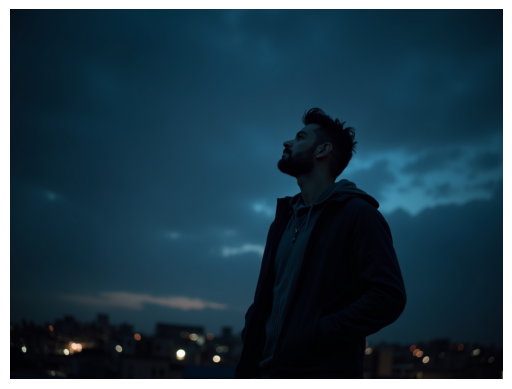

Generating description...
Image description: Please provide me with the image URL so I can access the picture and give you a detailed description. I need the image to be able to analyze the landscape, buildings, country, settings, and art style. 

Predicting emotion from the description...
Detected Emotion: sadness

Prediction Probability:
   emotions  probability
0     anger     0.001949
1   disgust     0.035939
2      fear     0.113786
3       joy     0.286703
4   neutral     0.000010
5   sadness     0.557744
6     shame     0.000053
7  surprise     0.003816


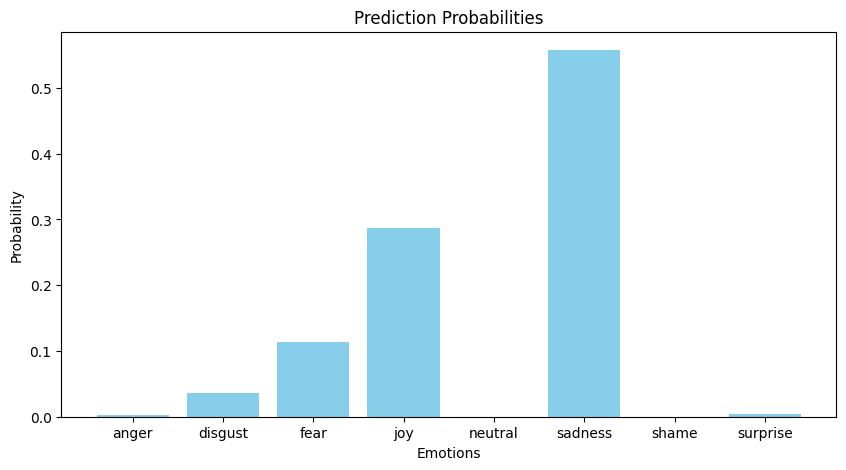

In [ ]:
# Import necessary libraries
import requests
from PIL import Image
from io import BytesIO
import google.generativeai as genai
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import getpass  # For hidden input

# Load your pre-trained emotion classifier model
pipe_lr = joblib.load(open(r"C:\Users\pavan\Downloads\emotion_classifier_pipe_lr.pkl", "rb"))

# Function to predict emotion from text description
def predict_emotions(docx):
    results = pipe_lr.predict([docx])
    return results[0]

# Function to get prediction probabilities
def get_prediction_proba(docx):
    results = pipe_lr.predict_proba([docx])
    return results

# Function to configure and create the Google Generative AI client
def create_google_client(api_key):
    genai.configure(api_key=api_key)
    
    class ClientFactory:
        def __init__(self):
            self.clients = {}
        
        def register_client(self, name, client_class):
            self.clients[name] = client_class
        
        def create_client(self, name, **kwargs):
            client_class = self.clients.get(name)
            if client_class:
                return client_class(**kwargs)
            raise ValueError(f"Client '{name}' is not registered.")
    
    # Register and create the Google generative AI client
    client_factory = ClientFactory()
    client_factory.register_client('google', genai.GenerativeModel)

    client_kwargs = {
        "model_name": "gemini-1.5-flash",
        "generation_config": {"temperature": 0.8},
        "system_instruction": None,
    }

    client = client_factory.create_client('google', **client_kwargs)
    return client

# Main function to run the process
def main():
    # Input: Google Gemini API key with password-like input
    api_key = getpass.getpass("Enter your Google Gemini API key: ")

    if api_key:
        # Create the Google client
        client = create_google_client(api_key)
        
        while True:  # Loop for entering multiple URLs
            # Input: Image URL
            image_url = input("Enter the image URL (or press Enter to skip): ")

            if image_url:
                try:
                    # Load and display the image from URL
                    response = requests.get(image_url)
                    img = Image.open(BytesIO(response.content))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.show()
                    
                    # Generate image description
                    print("Generating description...")
                    user_content = """Describe this picture, landscape, buildings, country, settings, and art style if any dictated. 
                                      Identify any signs and indicate what they may suggest."""
                    response = client.generate_content([user_content, image_url], stream=True)
                    response.resolve()
                    description = response.text
                    print(f"Image description: {description}")
                    
                except Exception as e:
                    print(f"Error loading image: {e}")
                    description = None
            else:
                description = None

            # Input: Manual Description
            if not description:
                description = input("Enter a manual description for emotion detection: ")

            if description:
                # Predict emotion based on the description
                print("Predicting emotion from the description...")
                emotion = predict_emotions(description)
                print(f"Detected Emotion: {emotion}")
                
                # Show prediction probabilities
                probability = get_prediction_proba(description)
                proba_df = pd.DataFrame(probability, columns=pipe_lr.classes_)
                proba_df_clean = proba_df.T.reset_index()
                proba_df_clean.columns = ["emotions", "probability"]
                
                print("\nPrediction Probability:")
                print(proba_df_clean)
                
                # Plot the probabilities
                plt.figure(figsize=(10, 5))
                plt.bar(proba_df_clean['emotions'], proba_df_clean['probability'], color='skyblue')
                plt.xlabel('Emotions')
                plt.ylabel('Probability')
                plt.title('Prediction Probabilities')
                plt.show()
            else:
                print("No description provided. Unable to predict emotions.")

            # Prompt to continue or exit
            continue_input = input("Do you want to enter another URL? (yes/no): ").strip().lower()
            if continue_input != 'yes':
                print("Exiting the program.")
                break
    else:
        print("Please enter your API key to proceed.")

# Run the main function
if __name__ == "__main__":
    main()
